# 🔬 Regularization Analysis v2: Comprehensive Loss Tracking & Gradual Regularization

This notebook provides an improved analysis of regularization effects with:
- **Comprehensive logging** of all loss types and total losses
- **Seeded runs** for reproducibility 
- **Early stopping** based on validation ELBO loss
- **Gradual regularization sweep** from 1e-8 to 10 for fine-grained analysis
- **Detailed tracking** of training dynamics

In [22]:
# Setup and imports
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Our custom modules
from regularized_ssm import RegularizedSSM, create_rotation_vector_field
from loss_analysis_utils import (
    LossComponentAnalyzer, 
    RegularizationStrengthAnalyzer,
    create_perfect_rotation_test
)
from regularizers import LieDerivativeRegularizer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# REPRODUCIBILITY: Set all seeds
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"🌱 All seeds set to {SEED} for reproducibility")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu
🌱 All seeds set to 41 for reproducibility


## 📋 Configuration and Data Generation

In [23]:
# Enhanced configuration for ring attractor analysis
class Config:
    # Model architecture
    n_latents = 2
    n_latents_read = 2  
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    # Training parameters
    n_samples = 5  # Reduced for ring attractor (more complex)
    batch_sz = 32
    learning_rate = 1e-3
    max_epochs = 25  # Reduced for initial analysis
    patience = 5  # Increased patience for ring attractor
    grad_clip = 1.0
    
    # Data parameters (matching demo_regularize.ipynb)
    n_trials = 1000  # Smaller for faster analysis
    n_neurons = 100  # Match demo_regularize.ipynb
    n_time_bins = 75  # Match demo_regularize.ipynb
    train_split = 0.8
    
    # Regularization sweep (gradual from very small to moderate)
    lambda_min = 1e-5  # Start smaller for ring attractor
    lambda_max = 10000.0   # Don't go too high, ring attractor is more complex
    n_lambda_points = 10  # More points in interesting range
    
    # Reproducibility
    seed = SEED

cfg = Config()

print(f"📋 Ring Attractor Configuration:")
print(f"   Data: {cfg.n_trials} trials × {cfg.n_time_bins} time bins × {cfg.n_neurons} neurons")
print(f"   Model: {cfg.n_latents}D latent space, {cfg.n_hidden_dynamics} hidden dynamics")
print(f"   Training: max {cfg.max_epochs} epochs, lr={cfg.learning_rate}, patience={cfg.patience}")
print(f"   Samples: {cfg.n_samples} (reduced for ring attractor complexity)")
print(f"   Regularization sweep: {cfg.lambda_min:.1e} to {cfg.lambda_max} ({cfg.n_lambda_points} points)")
print(f"   Focus: Ring attractor data → Rotational symmetry regularization")

📋 Ring Attractor Configuration:
   Data: 1000 trials × 75 time bins × 100 neurons
   Model: 2D latent space, 32 hidden dynamics
   Training: max 25 epochs, lr=0.001, patience=5
   Samples: 5 (reduced for ring attractor complexity)
   Regularization sweep: 1.0e-05 to 10000.0 (10 points)
   Focus: Ring attractor data → Rotational symmetry regularization


In [24]:
# Create ring attractor dynamics and synthetic data (like demo_regularize.ipynb)
import importlib.util

# Load the PerturbedRingAttractorDynamics
file_path = "test_dynamics.py"
module_name = "test_dynamics"

spec = importlib.util.spec_from_file_location(module_name, file_path)
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

print("🔄 Generating ring attractor data with perturbations...")

# Ring attractor parameters
perturbation_magnitude = 0.1

# Create true ring attractor dynamics (perturbed - used for data generation)
true_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1, 
    lengthscale=0.2, 
    perturbation_magnitude=perturbation_magnitude
).to(device)

# Create perfect ring attractor dynamics (unperturbed - for comparison)
perfect_ring_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1, 
    lengthscale=0.2, 
    perturbation_magnitude=0.0  # No perturbations = perfect ring
).to(device)

# Target field is rotational symmetry (different from both ring attractors!)
target_field = create_rotation_vector_field(rotation_speed=0.5)

print(f"✅ Ring attractor setup:")
print(f"   True dynamics: PerturbedRingAttractor (perturbation = {perturbation_magnitude})")
print(f"   Perfect ring: PerturbedRingAttractor (perturbation = 0.0)")
print(f"   Target field: Rotational symmetry (speed = 0.5)")
print(f"   Goal: Learn to fit perturbed ring data while being regularized toward rotation")

# Observation matrix and noise parameters (matching demo_regularize.ipynb)
C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=device)  # Process noise
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)  # Initial condition noise  
R_diag = 1e-1 * torch.ones(cfg.n_neurons, device=device)  # Observation noise
m_0 = torch.zeros(cfg.n_latents, device=device)  # Initial mean

# Generate ring attractor trajectories and observations using the PERTURBED dynamics
print(f"   Generating {cfg.n_trials} trials from perturbed ring attractor...")
z_true = utils.sample_gauss_z(true_dynamics, Q_diag, m_0, Q_0_diag, cfg.n_trials, cfg.n_time_bins)
y = C(z_true) + torch.sqrt(R_diag) * torch.randn((cfg.n_trials, cfg.n_time_bins, cfg.n_neurons), device=device)
y = y.detach()

# Split into train and validation
n_train = int(cfg.train_split * cfg.n_trials)
y_train = y[:n_train]
y_valid = y[n_train:]

print(f"✅ Ring attractor data generated and split:")
print(f"   Training: {y_train.shape[0]} trials")
print(f"   Validation: {y_valid.shape[0]} trials")
print(f"   True latents: {z_true.shape}")
print(f"   Observations: {y.shape}")
print(f"\n🎯 Three vector fields for comparison:")
print(f"   1. Learned dynamics (what we train)")
print(f"   2. Perfect ring attractor (unperturbed)")
print(f"   3. Perturbed ring attractor (data generation)")

🔄 Generating ring attractor data with perturbations...
✅ Ring attractor setup:
   True dynamics: PerturbedRingAttractor (perturbation = 0.1)
   Perfect ring: PerturbedRingAttractor (perturbation = 0.0)
   Target field: Rotational symmetry (speed = 0.5)
   Goal: Learn to fit perturbed ring data while being regularized toward rotation
   Generating 1000 trials from perturbed ring attractor...
✅ Ring attractor data generated and split:
   Training: 800 trials
   Validation: 200 trials
   True latents: torch.Size([1000, 75, 2])
   Observations: torch.Size([1000, 75, 100])

🎯 Three vector fields for comparison:
   1. Learned dynamics (what we train)
   2. Perfect ring attractor (unperturbed)
   3. Perturbed ring attractor (data generation)


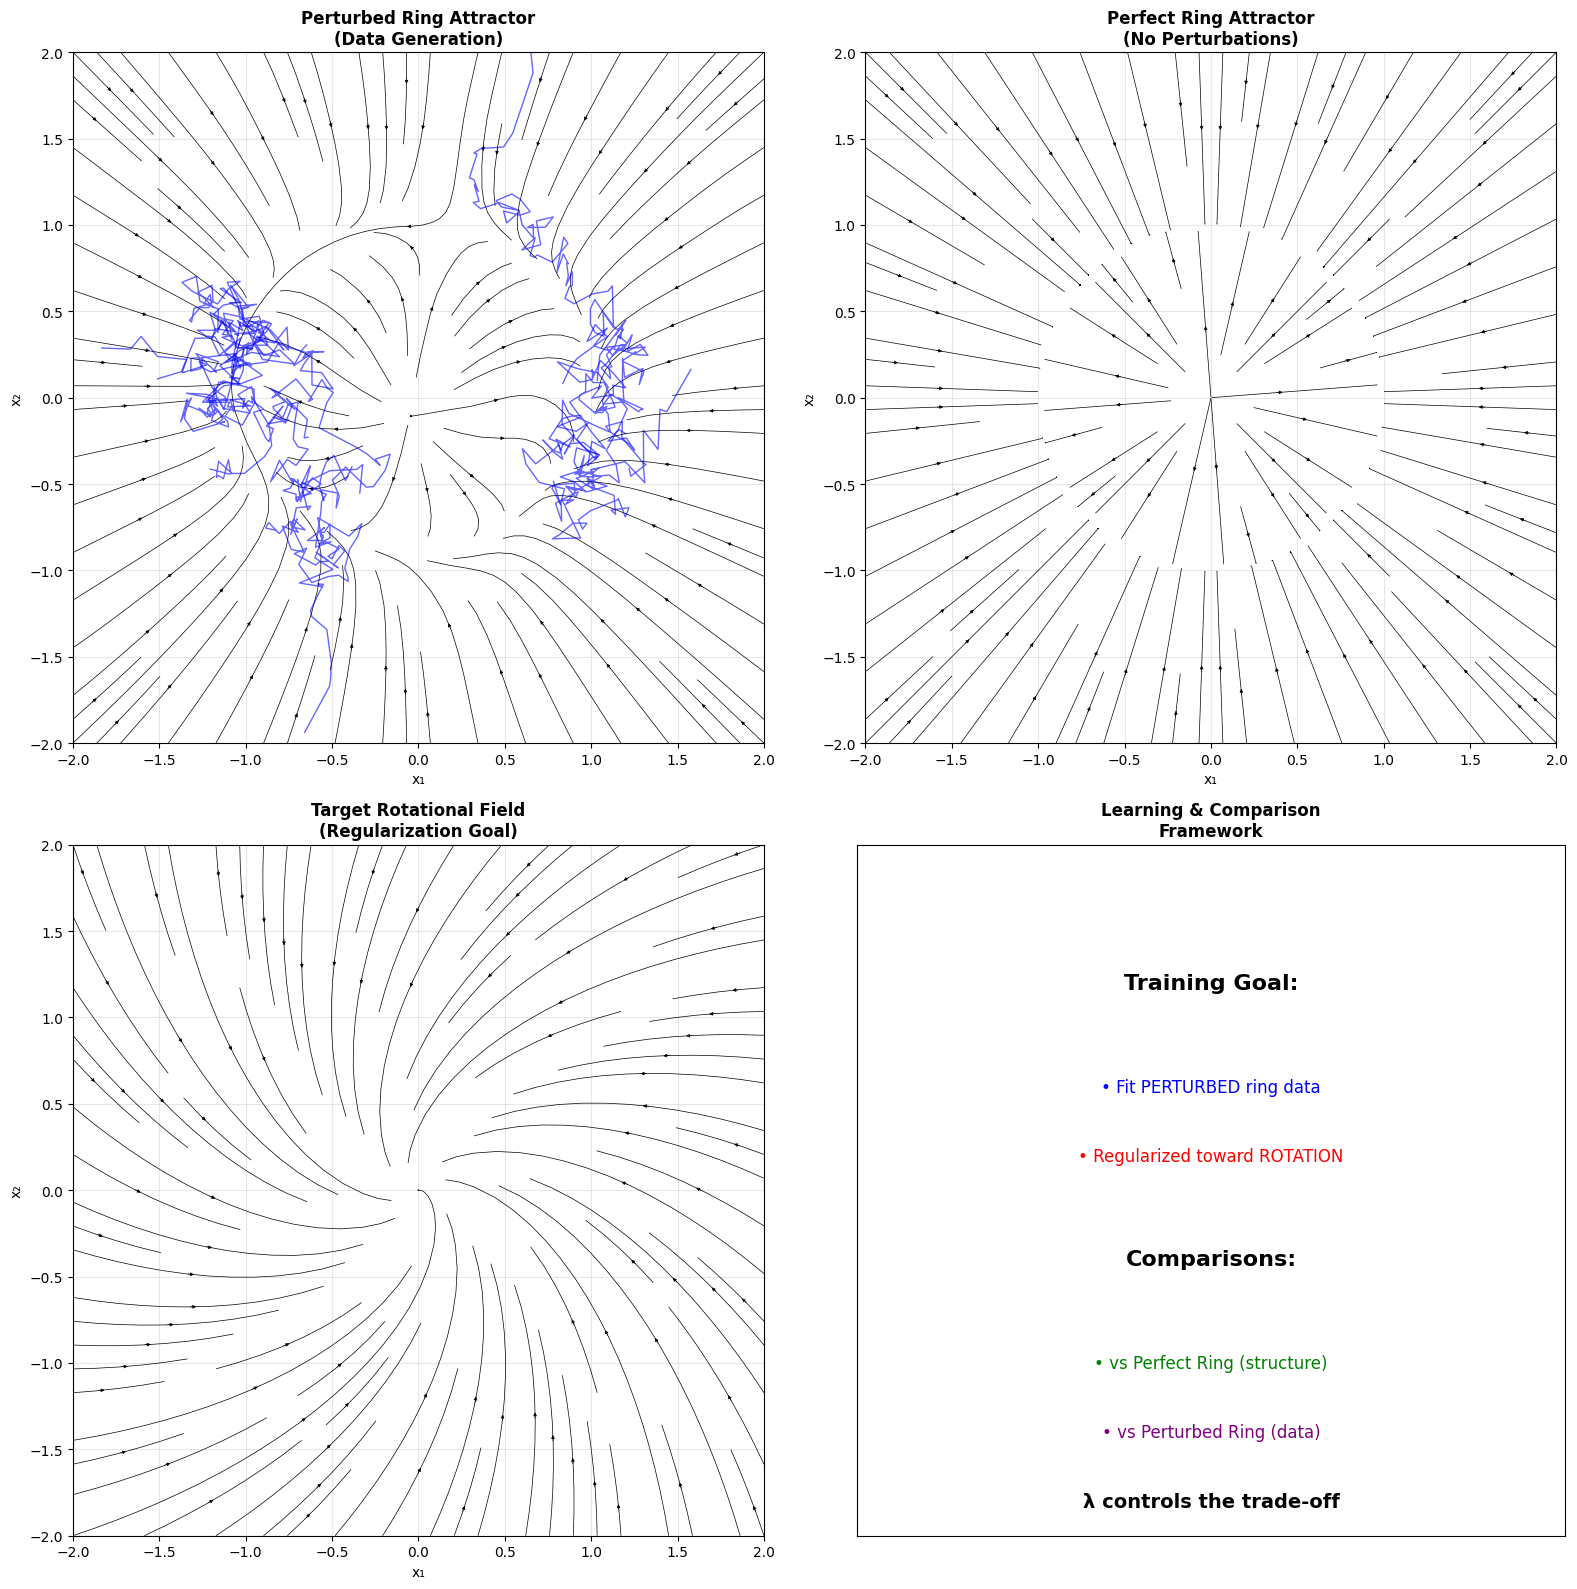

📊 Ring attractor setup visualization saved as 'ring_attractor_setup_v2.png'
🎯 This comprehensive setup allows us to understand:
   - How learning deviates from the data-generating process
   - How regularization pulls toward rotation symmetry
   - How close we get to the perfect ring structure
   - Trade-offs between data fitting and regularization


In [25]:
# Visualize the setup: All three vector fields
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# 1. True perturbed ring attractor dynamics + trajectories  
ax = axes[0, 0]
plot_utils.plot_two_d_vector_field(true_dynamics.to('cpu'), ax, min_xy=-2, max_xy=2)
for i in range(10):  # Plot subset of trajectories
    ax.plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 'b-', alpha=0.6, linewidth=1)
ax.set_title('Perturbed Ring Attractor\n(Data Generation)', fontweight='bold')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# 2. Perfect ring attractor dynamics
ax = axes[0, 1]
plot_utils.plot_two_d_vector_field(perfect_ring_dynamics.to('cpu'), ax, min_xy=-2, max_xy=2)
ax.set_title('Perfect Ring Attractor\n(No Perturbations)', fontweight='bold')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# 3. Target rotational field
ax = axes[1, 0]
# plot_utils.plot_two_d_vector_field(
#     lambda x: x + 1e-2 * target_field(x), ax, min_xy=-2, max_xy=2
# )
plot_utils.plot_two_d_vector_field(
    target_field, ax, min_xy=-2, max_xy=2
)
ax.set_title('Target Rotational Field\n(Regularization Goal)', fontweight='bold')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# 4. Conceptual illustration
ax = axes[1, 1]
ax.text(0.5, 0.8, 'Training Goal:', ha='center', va='center', fontsize=16, fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.65, '• Fit PERTURBED ring data', ha='center', va='center', fontsize=12, transform=ax.transAxes, color='blue')
ax.text(0.5, 0.55, '• Regularized toward ROTATION', ha='center', va='center', fontsize=12, transform=ax.transAxes, color='red')

ax.text(0.5, 0.4, 'Comparisons:', ha='center', va='center', fontsize=16, fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.25, '• vs Perfect Ring (structure)', ha='center', va='center', fontsize=12, transform=ax.transAxes, color='green')
ax.text(0.5, 0.15, '• vs Perturbed Ring (data)', ha='center', va='center', fontsize=12, transform=ax.transAxes, color='purple')

ax.text(0.5, 0.05, 'λ controls the trade-off', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Learning & Comparison\nFramework', fontweight='bold')

# plt.suptitle('Ring Attractor Analysis: Data vs Regularization vs Comparisons', 
            #  fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.savefig('ring_attractor_setup_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Ring attractor setup visualization saved as 'ring_attractor_setup_v2.png'")
print("🎯 This comprehensive setup allows us to understand:")
print("   - How learning deviates from the data-generating process")  
print("   - How regularization pulls toward rotation symmetry")
print("   - How close we get to the perfect ring structure")
print("   - Trade-offs between data fitting and regularization")

## 🏗️ Enhanced SSM Factory and Training Functions

In [26]:
def create_regularized_ssm(lambda_lie=1.0, lambda_curvature=0.0):
    """Factory function to create RegularizedSSM with given parameters."""
    
    # Likelihood
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    # Learnable dynamics
    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    # Initial condition
    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    # Encoders
    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    # Nonlinear filtering
    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    # Create regularized SSM
    regularized_ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_field,
        lambda_lie=lambda_lie,
        lambda_curvature=lambda_curvature,
        lie_normalize="yang",
        device=device
    )
    
    return regularized_ssm

In [27]:
class ComprehensiveLossLogger:
    """Enhanced logger that tracks loss components and creates comprehensive vector field visualizations."""
    
    def __init__(self, experiment_name=None, save_vector_fields=True, perfect_ring_dynamics=None, 
                 perturbed_ring_dynamics=None, target_field=None):
        self.experiment_name = experiment_name or "unknown_experiment"
        self.save_vector_fields = save_vector_fields
        self.vector_field_save_dir = None
        
        # Store reference dynamics for comparison
        self.perfect_ring_dynamics = perfect_ring_dynamics
        self.perturbed_ring_dynamics = perturbed_ring_dynamics  
        self.target_field = target_field
        
        self.reset()
        
        # Set up vector field saving directory
        if self.save_vector_fields:
            self.vector_field_save_dir = Path(f'vector_field_plots/{self.experiment_name}')
            self.vector_field_save_dir.mkdir(parents=True, exist_ok=True)
            print(f"📁 Vector field plots will be saved to: {self.vector_field_save_dir}")
    
    def reset(self):
        self.train_logs = defaultdict(list)
        self.valid_logs = defaultdict(list)
        self.epochs = []
    
    def compute_vector_field_differences(self, learned_dynamics, grid_size=50):
        """
        Compute differences between learned dynamics and reference fields on a grid.
        
        Returns:
            dict: Contains grid points and difference magnitudes for each comparison
        """
        # Create evaluation grid
        x = np.linspace(-2, 2, grid_size)
        y = np.linspace(-2, 2, grid_size)
        X, Y = np.meshgrid(x, y)
        grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
        
        # Evaluate learned dynamics
        with torch.no_grad():
            learned_output = learned_dynamics(grid_points)
            learned_field = learned_output - grid_points  # Convert to vector field
        
        differences = {}
        
        # Difference from perfect ring attractor
        if self.perfect_ring_dynamics is not None:
            with torch.no_grad():
                perfect_output = self.perfect_ring_dynamics(grid_points)
                perfect_field = perfect_output - grid_points
                diff_perfect = learned_field - perfect_field
                diff_perfect_magnitude = torch.norm(diff_perfect, dim=1)
                differences['perfect_ring'] = {
                    'grid_points': grid_points.numpy(),
                    'grid_shape': (grid_size, grid_size),
                    'difference_magnitude': diff_perfect_magnitude.numpy(),
                    'difference_vector': diff_perfect.numpy(),
                    'max_diff': diff_perfect_magnitude.max().item(),
                    'mean_diff': diff_perfect_magnitude.mean().item()
                }
        
        # Difference from perturbed ring attractor (data generation)
        if self.perturbed_ring_dynamics is not None:
            with torch.no_grad():
                perturbed_output = self.perturbed_ring_dynamics(grid_points)
                perturbed_field = perturbed_output - grid_points
                diff_perturbed = learned_field - perturbed_field
                diff_perturbed_magnitude = torch.norm(diff_perturbed, dim=1)
                differences['perturbed_ring'] = {
                    'grid_points': grid_points.numpy(),
                    'grid_shape': (grid_size, grid_size),
                    'difference_magnitude': diff_perturbed_magnitude.numpy(),
                    'difference_vector': diff_perturbed.numpy(),
                    'max_diff': diff_perturbed_magnitude.max().item(),
                    'mean_diff': diff_perturbed_magnitude.mean().item()
                }
        
        # Difference from target rotational field
        if self.target_field is not None:
            with torch.no_grad():
                target_output = self.target_field(grid_points)
                diff_target = learned_field - target_output
                diff_target_magnitude = torch.norm(diff_target, dim=1)
                differences['target_rotation'] = {
                    'grid_points': grid_points.numpy(),
                    'grid_shape': (grid_size, grid_size),
                    'difference_magnitude': diff_target_magnitude.numpy(),
                    'difference_vector': diff_target.numpy(),
                    'max_diff': diff_target_magnitude.max().item(),
                    'mean_diff': diff_target_magnitude.mean().item()
                }
        
        return differences
    
    def plot_comprehensive_vector_field_analysis(self, ssm, epoch, label=None):
        """
        Create comprehensive vector field analysis including learned field and difference heatmaps.
        """
        if not self.save_vector_fields or self.vector_field_save_dir is None:
            return
        
        # Compute differences
        differences = self.compute_vector_field_differences(ssm.dynamics_mod.mean_fn)
        
        # Determine subplot layout based on available comparisons
        n_comparisons = len(differences)
        if n_comparisons == 0:
            # Just plot learned field
            fig, ax = plt.subplots(figsize=(8, 8))
            axes = [ax]
            titles = ['Learned Vector Field']
        else:
            # Plot learned field + difference heatmaps
            n_cols = min(4, n_comparisons + 1)  # Learned + up to 3 comparisons
            n_rows = (n_comparisons + 1 + n_cols - 1) // n_cols  # Ceiling division
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
            if n_rows == 1:
                axes = axes if n_cols > 1 else [axes]
            else:
                axes = axes.flatten()
        
        # 1. Plot learned vector field
        ax = axes[0]
        plot_utils.plot_two_d_vector_field(ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
        ax.set_title('Learned Vector Field', fontsize=14, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # 2. Plot difference heatmaps
        comparison_names = {
            'perfect_ring': 'Diff from Perfect Ring',
            'perturbed_ring': 'Diff from Perturbed Ring', 
            'target_rotation': 'Diff from Target Rotation'
        }
        
        for i, (key, diff_data) in enumerate(differences.items()):
            if i + 1 >= len(axes):
                break
                
            ax = axes[i + 1]
            
            # Reshape difference magnitude for heatmap
            diff_magnitude = diff_data['difference_magnitude'].reshape(diff_data['grid_shape'])
            X = diff_data['grid_points'][:, 0].reshape(diff_data['grid_shape'])
            Y = diff_data['grid_points'][:, 1].reshape(diff_data['grid_shape'])
            
            # Create heatmap
            im = ax.contourf(X, Y, diff_magnitude, levels=20, cmap='viridis')
            ax.contour(X, Y, diff_magnitude, levels=10, colors='white', alpha=0.3, linewidths=0.5)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Difference Magnitude', rotation=270, labelpad=15)
            
            ax.set_title(f'{comparison_names[key]}\\nMax: {diff_data["max_diff"]:.3f}, Mean: {diff_data["mean_diff"]:.3f}', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('x₁')
            ax.set_ylabel('x₂')
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(differences) + 1, len(axes)):
            axes[i].set_visible(False)
        
        # Set main title
        if label:
            main_title = f'Vector Field Analysis - {label.title()} (Epoch {epoch})'
        else:
            main_title = f'Vector Field Analysis - Epoch {epoch}'
            
        plt.suptitle(main_title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save the comprehensive plot
        if label:
            filename = f'vector_field_analysis_epoch_{epoch:03d}_{label}.png'
        else:
            filename = f'vector_field_analysis_epoch_{epoch:03d}.png'
            
        save_path = self.vector_field_save_dir / filename
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close to save memory
        
        if epoch % 10 == 0 or label:  # Only print occasionally to avoid spam
            print(f"📊 Comprehensive vector field analysis saved: {save_path}")
        
        return differences
    
    def plot_and_save_vector_field(self, ssm, epoch, label=None):
        """
        Plot and save both the basic vector field AND comprehensive analysis.
        """
        if not self.save_vector_fields or self.vector_field_save_dir is None:
            return
        
        # 1. Basic vector field plot (for GIF creation)
        fig, ax = plt.subplots(figsize=(8, 8))
        plot_utils.plot_two_d_vector_field(ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
        
        if label:
            title = f'Vector Field - {label.title()} (Epoch {epoch})'
        else:
            title = f'Vector Field - Epoch {epoch}'
            
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        if label:
            filename = f'vector_field_epoch_{epoch:03d}_{label}.png'
        else:
            filename = f'vector_field_epoch_{epoch:03d}.png'
            
        save_path = self.vector_field_save_dir / filename
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        # 2. Comprehensive analysis with heatmaps
        differences = self.plot_comprehensive_vector_field_analysis(ssm, epoch, label)
        
        return differences
    
    def create_before_after_comparison(self, ssm):
        """
        Create comprehensive before/after comparison with all reference fields.
        """
        if not self.save_vector_fields or self.vector_field_save_dir is None:
            return
            
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Top row: Reference fields
        if self.perfect_ring_dynamics is not None:
            plot_utils.plot_two_d_vector_field(self.perfect_ring_dynamics, axes[0, 0], min_xy=-2, max_xy=2)
            axes[0, 0].set_title('Perfect Ring Attractor', fontsize=12, fontweight='bold')
        else:
            axes[0, 0].text(0.5, 0.5, 'Perfect Ring\nNot Available', ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Perfect Ring Attractor', fontsize=12, fontweight='bold')
        
        if self.perturbed_ring_dynamics is not None:
            plot_utils.plot_two_d_vector_field(self.perturbed_ring_dynamics, axes[0, 1], min_xy=-2, max_xy=2)
            axes[0, 1].set_title('Perturbed Ring (Data)', fontsize=12, fontweight='bold')
        else:
            axes[0, 1].text(0.5, 0.5, 'Perturbed Ring\nNot Available', ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Perturbed Ring (Data)', fontsize=12, fontweight='bold')
        
        if self.target_field is not None:
            plot_utils.plot_two_d_vector_field(self.target_field, axes[0, 2], min_xy=-2, max_xy=2)
            axes[0, 2].set_title('Target Rotation', fontsize=12, fontweight='bold')
        else:
            axes[0, 2].text(0.5, 0.5, 'Target Field\nNot Available', ha='center', va='center', transform=axes[0, 2].transAxes)
            axes[0, 2].set_title('Target Rotation', fontsize=12, fontweight='bold')
        
        # Bottom row: Learned field and key differences
        plot_utils.plot_two_d_vector_field(ssm.dynamics_mod.mean_fn, axes[1, 0], min_xy=-2, max_xy=2)
        axes[1, 0].set_title('Final Learned Field', fontsize=12, fontweight='bold')
        
        # Compute final differences for summary
        differences = self.compute_vector_field_differences(ssm.dynamics_mod.mean_fn, grid_size=30)
        
        # Show most relevant difference heatmaps
        if 'perturbed_ring' in differences:
            diff_data = differences['perturbed_ring']
            diff_magnitude = diff_data['difference_magnitude'].reshape(diff_data['grid_shape'])
            X = diff_data['grid_points'][:, 0].reshape(diff_data['grid_shape'])
            Y = diff_data['grid_points'][:, 1].reshape(diff_data['grid_shape'])
            
            im = axes[1, 1].contourf(X, Y, diff_magnitude, levels=15, cmap='viridis')
            axes[1, 1].set_title(f'Diff from Data Gen\\n(Mean: {diff_data["mean_diff"]:.3f})', fontsize=12, fontweight='bold')
            plt.colorbar(im, ax=axes[1, 1])
        
        if 'target_rotation' in differences:
            diff_data = differences['target_rotation']
            diff_magnitude = diff_data['difference_magnitude'].reshape(diff_data['grid_shape'])
            X = diff_data['grid_points'][:, 0].reshape(diff_data['grid_shape'])
            Y = diff_data['grid_points'][:, 1].reshape(diff_data['grid_shape'])
            
            im = axes[1, 2].contourf(X, Y, diff_magnitude, levels=15, cmap='plasma')
            axes[1, 2].set_title(f'Diff from Target\\n(Mean: {diff_data["mean_diff"]:.3f})', fontsize=12, fontweight='bold')
            plt.colorbar(im, ax=axes[1, 2])
        
        # Format all axes
        for ax in axes.flat:
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('x₁')
            ax.set_ylabel('x₂')
        
        plt.suptitle(f'Comprehensive Vector Field Comparison (λ={ssm.lambda_lie:.2e})', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save comparison
        comparison_path = self.vector_field_save_dir / 'comprehensive_comparison.png'
        fig.savefig(comparison_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        print(f"📊 Comprehensive comparison plot saved: {comparison_path}")
        
    def log_epoch(self, epoch, train_stats, valid_stats):
        """Log key loss components for both training and validation."""
        self.epochs.append(epoch)
        
        # Define which losses to track
        loss_keys = ['total_loss', 'elbo_loss', 'lie_loss', 'recon_loss', 'kl_loss', 'total_reg_loss']
        
        # Log training losses
        for key in loss_keys:
            if key in train_stats:
                value = train_stats[key]
                if isinstance(value, torch.Tensor):
                    self.train_logs[key].append(value.item())
                else:
                    self.train_logs[key].append(value)
        
        # Log validation losses
        for key in loss_keys:
            if key in valid_stats:
                value = valid_stats[key]
                if isinstance(value, torch.Tensor):
                    self.valid_logs[key].append(value.item())
                else:
                    self.valid_logs[key].append(value)
    
    def get_dataframe(self):
        """Convert logs to pandas DataFrame for analysis."""
        data = {'epoch': self.epochs}
        
        # Add training data with 'train_' prefix
        for key, values in self.train_logs.items():
            data[f'train_{key}'] = values
            
        # Add validation data with 'valid_' prefix
        for key, values in self.valid_logs.items():
            data[f'valid_{key}'] = values
            
        return pd.DataFrame(data)
    
    def plot_training_curves(self, save_path=None):
        """Plot training curves for the tracked losses."""
        df = self.get_dataframe()
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Define what to plot
        loss_types = ['total_loss', 'elbo_loss', 'lie_loss', 'recon_loss', 'kl_loss', 'total_reg_loss']
        
        for i, loss_type in enumerate(loss_types):
            ax = axes[i]
            
            train_col = f'train_{loss_type}'
            valid_col = f'valid_{loss_type}'
            
            if train_col in df.columns:
                ax.semilogy(df['epoch'], df[train_col], 'b-', label='Train', linewidth=2)
            if valid_col in df.columns:
                ax.semilogy(df['epoch'], df[valid_col], 'r-', label='Valid', linewidth=2)
                
            ax.set_title(loss_type.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig

In [28]:
def train_with_comprehensive_logging(ssm, y_train, y_valid, logger, lambda_lie=1.0):
    """Enhanced training function with comprehensive loss logging, early stopping, and vector field plotting."""
    
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    # Early stopping based on validation ELBO
    best_valid_elbo = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"🚀 Training with λ_lie = {lambda_lie:.2e}")
    print(f"   Max epochs: {cfg.max_epochs}, Patience: {cfg.patience}")
    print(f"   Early stopping on: validation ELBO loss")
    
    # Plot and save initial vector field (before training)
    logger.plot_and_save_vector_field(ssm, epoch=-1, label="initial")
    
    # Get initial losses before any training (epoch 0)
    ssm.eval()
    with torch.no_grad():
        # Initial training loss (small batch to match training)
        train_batch = y_train[:cfg.batch_sz]
        initial_train_loss, _, initial_train_stats = ssm(train_batch, cfg.n_samples)
        
        # Initial validation loss
        initial_valid_loss, _, initial_valid_stats = ssm(y_valid, cfg.n_samples)
    
    # Log initial state
    logger.log_epoch(0, initial_train_stats, initial_valid_stats)
    print(f"   Initial: Train ELBO = {initial_train_stats['elbo_loss']:.3f}, "
          f"Valid ELBO = {initial_valid_stats['elbo_loss']:.3f}, "
          f"Lie = {initial_valid_stats['lie_loss']:.3f}")
    
    for epoch in range(1, cfg.max_epochs + 1):
        # Training phase
        ssm.train()
        train_losses = []
        
        # Shuffle training data
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        # Average training statistics
        train_stats = {}
        for key in train_losses[0].keys():
            train_stats[key] = torch.stack([batch[key] for batch in train_losses]).mean()
        
        # Validation phase
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        # Log epoch
        logger.log_epoch(epoch, train_stats, valid_stats)
        
        # Plot and save vector field after this epoch
        logger.plot_and_save_vector_field(ssm, epoch)
        
        # Early stopping check (using validation ELBO)
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
            best_model_state = ssm.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if epoch % 10 == 0 or patience_counter == 0:
            print(f"   Epoch {epoch:3d}: Train ELBO = {train_stats['elbo_loss']:.3f}, "
                  f"Valid ELBO = {current_valid_elbo:.3f}, "
                  f"Lie = {valid_stats['lie_loss']:.3f}, "
                  f"Patience = {patience_counter}/{cfg.patience}")
        
        # Early stopping
        # if patience_counter >= cfg.patience:
        #     print(f"   🛑 Early stopping at epoch {epoch} (best valid ELBO: {best_valid_elbo:.6f})")
        #     break
    
    # Restore best model
    if best_model_state is not None:
        ssm.load_state_dict(best_model_state)
        print(f"   ✅ Restored model with best validation ELBO: {best_valid_elbo:.6f}")
    
    # Plot and save final vector field
    logger.plot_and_save_vector_field(ssm, epoch, label="final")
    
    # Create target vs final comparison
    logger.create_before_after_comparison(ssm)
    
    print(f"🎯 All vector field plots saved to: {logger.vector_field_save_dir}")
    
    return {
        'final_epoch': epoch,
        'best_valid_elbo': best_valid_elbo,
        'converged': patience_counter < cfg.patience
    }

## 🔍 Gradual Regularization Strength Analysis

In [29]:
# Define gradual lambda sweep (much more fine-grained), including 0
lambda_values = np.concatenate(([0.0], np.logspace(np.log10(cfg.lambda_min), np.log10(cfg.lambda_max), cfg.n_lambda_points)))

print(f"🔬 Gradual regularization analysis:")
print(f"   Range: 0.0 to {cfg.lambda_max}")
print(f"   Points: {len(lambda_values)} (logarithmically spaced, plus 0)")
print(f"   First few values: {[f'{x:.2e}' for x in lambda_values[:5]]}")
print(f"   Last few values: {[f'{x:.2e}' for x in lambda_values[-5:]]}")

# Storage for results
all_results = []
all_loggers = {}
trained_models = {}

print(f"\n🚀 Starting training sweep...")
start_time = time.time()

🔬 Gradual regularization analysis:
   Range: 0.0 to 10000.0
   Points: 11 (logarithmically spaced, plus 0)
   First few values: ['0.00e+00', '1.00e-05', '1.00e-04', '1.00e-03', '1.00e-02']
   Last few values: ['1.00e+00', '1.00e+01', '1.00e+02', '1.00e+03', '1.00e+04']

🚀 Starting training sweep...


In [30]:
# Run training for each lambda value with comprehensive vector field analysis
for i, lambda_lie in enumerate(lambda_values):
    print(f"\n--- Training {i+1}/{len(lambda_values)}: λ = {lambda_lie:.2e} ---")
    
    # Reset seed before each model creation for identical initialization
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(cfg.seed)
    
    # Create fresh model
    ssm = create_regularized_ssm(lambda_lie=lambda_lie)
    
    # Create enhanced logger with reference dynamics for comparison
    experiment_name = f"lambda_{lambda_lie:.2e}".replace(".", "_").replace("+", "").replace("-", "neg")
    logger = ComprehensiveLossLogger(
        experiment_name=experiment_name, 
        save_vector_fields=True,
        perfect_ring_dynamics=perfect_ring_dynamics,  # Perfect ring (no perturbations)
        perturbed_ring_dynamics=true_dynamics,        # Perturbed ring (data generation)
        target_field=target_field                     # Rotational target field
    )
    
    # Train with comprehensive logging and vector field analysis
    training_result = train_with_comprehensive_logging(
        ssm, y_train, y_valid, logger, lambda_lie=lambda_lie
    )
    
    # Get final validation statistics
    ssm.eval()
    with torch.no_grad():
        final_total_loss, _, final_stats = ssm(y_valid, cfg.n_samples)
    
    # Store results with comprehensive information
    result = {
        'lambda_lie': lambda_lie,
        'final_epoch': training_result['final_epoch'],
        'best_valid_elbo': training_result['best_valid_elbo'],
        'converged': training_result['converged'],
        'final_total_loss': final_total_loss.item(),
        'final_elbo_loss': final_stats['elbo_loss'].item(),
        'final_lie_loss': final_stats['lie_loss'].item(),
        'final_total_reg_loss': final_stats['total_reg_loss'].item(),
        'experiment_name': experiment_name,
        'vector_field_dir': str(logger.vector_field_save_dir)
    }
    
    # Add optional keys if they exist
    if 'recon_loss' in final_stats:
        result['final_recon_loss'] = final_stats['recon_loss'].item()
    if 'kl_loss' in final_stats:
        result['final_kl_loss'] = final_stats['kl_loss'].item()
    
    # Compute final vector field differences for quantitative analysis
    final_differences = logger.compute_vector_field_differences(ssm.dynamics_mod.mean_fn)
    for ref_name, diff_data in final_differences.items():
        result[f'final_diff_{ref_name}_mean'] = diff_data['mean_diff']
        result[f'final_diff_{ref_name}_max'] = diff_data['max_diff']
    
    all_results.append(result)
    all_loggers[lambda_lie] = logger
    trained_models[lambda_lie] = ssm.state_dict().copy()
    
    print(f"   Final: ELBO = {result['final_elbo_loss']:.3f}, "
          f"Lie = {result['final_lie_loss']:.3f}, "
          f"Total = {result['final_total_loss']:.3f}")
    print(f"   📁 Comprehensive analysis saved to: {result['vector_field_dir']}")
    
    # Print difference summary
    for ref_name, diff_data in final_differences.items():
        print(f"   📊 Diff from {ref_name}: mean={diff_data['mean_diff']:.3f}, max={diff_data['max_diff']:.3f}")

elapsed_time = time.time() - start_time
print(f"\n✅ Comprehensive sweep completed in {elapsed_time/60:.1f} minutes")
print(f"   Trained {len(all_results)} models successfully")
print(f"   📊 Vector field evolution + difference heatmaps saved for each experiment")
print(f"   📁 All comprehensive analyses organized in: vector_field_plots/")
print(f"\n🎬 Each experiment now includes:")
print(f"   - Initial vector field + difference heatmaps")
print(f"   - Vector field + difference heatmaps after each epoch")
print(f"   - Final vector field + difference heatmaps")
print(f"   - Comprehensive comparison with all reference fields")
print(f"\n🌟 Three-way comparison analysis:")
print(f"   🔵 Perfect Ring: Shows structural deviations")
print(f"   🟣 Perturbed Ring: Shows data fitting accuracy")  
print(f"   🔴 Target Rotation: Shows regularization effectiveness")


--- Training 1/11: λ = 0.00e+00 ---
📁 Vector field plots will be saved to: vector_field_plots/lambda_0_00e00
🚀 Training with λ_lie = 0.00e+00
   Max epochs: 25, Patience: 5
   Early stopping on: validation ELBO loss
📊 Comprehensive vector field analysis saved: vector_field_plots/lambda_0_00e00/vector_field_analysis_epoch_-01_initial.png
   Initial: Train ELBO = 26459.432, Valid ELBO = 26546.447, Lie = 0.000
   Epoch   1: Train ELBO = 26493.727, Valid ELBO = 25741.840, Lie = 0.000, Patience = 0/5
   Epoch   2: Train ELBO = 25176.605, Valid ELBO = 24184.393, Lie = 0.000, Patience = 0/5
   Epoch   3: Train ELBO = 20996.812, Valid ELBO = 18267.533, Lie = 0.000, Patience = 0/5
   Epoch   4: Train ELBO = 14295.619, Valid ELBO = 11121.500, Lie = 0.000, Patience = 0/5
   Epoch   5: Train ELBO = 6891.831, Valid ELBO = 3852.827, Lie = 0.000, Patience = 0/5
   Epoch   6: Train ELBO = 3435.986, Valid ELBO = 3122.870, Lie = 0.000, Patience = 0/5
   Epoch   7: Train ELBO = 3040.158, Valid ELBO = 29

## 📊 Comprehensive Analysis and Visualization

In [31]:
# Convert results to DataFrame for analysis
df_results = pd.DataFrame(all_results)

print(f"📊 Training Results Summary:")
print(f"   Converged models: {df_results['converged'].sum()}/{len(df_results)}")
print(f"   Average final epoch: {df_results['final_epoch'].mean():.1f}")
print(f"   ELBO loss range: {df_results['final_elbo_loss'].min():.3f} - {df_results['final_elbo_loss'].max():.3f}")
print(f"   Lie loss range: {df_results['final_lie_loss'].min():.3e} - {df_results['final_lie_loss'].max():.3e}")

# Save results
df_results.to_csv('regularization_sweep_results_v2.csv', index=False)
print(f"💾 Results saved to regularization_sweep_results_v2.csv")

📊 Training Results Summary:
   Converged models: 10/11
   Average final epoch: 25.0
   ELBO loss range: 2378.917 - 40947.293
   Lie loss range: 0.000e+00 - 1.867e+05
💾 Results saved to regularization_sweep_results_v2.csv


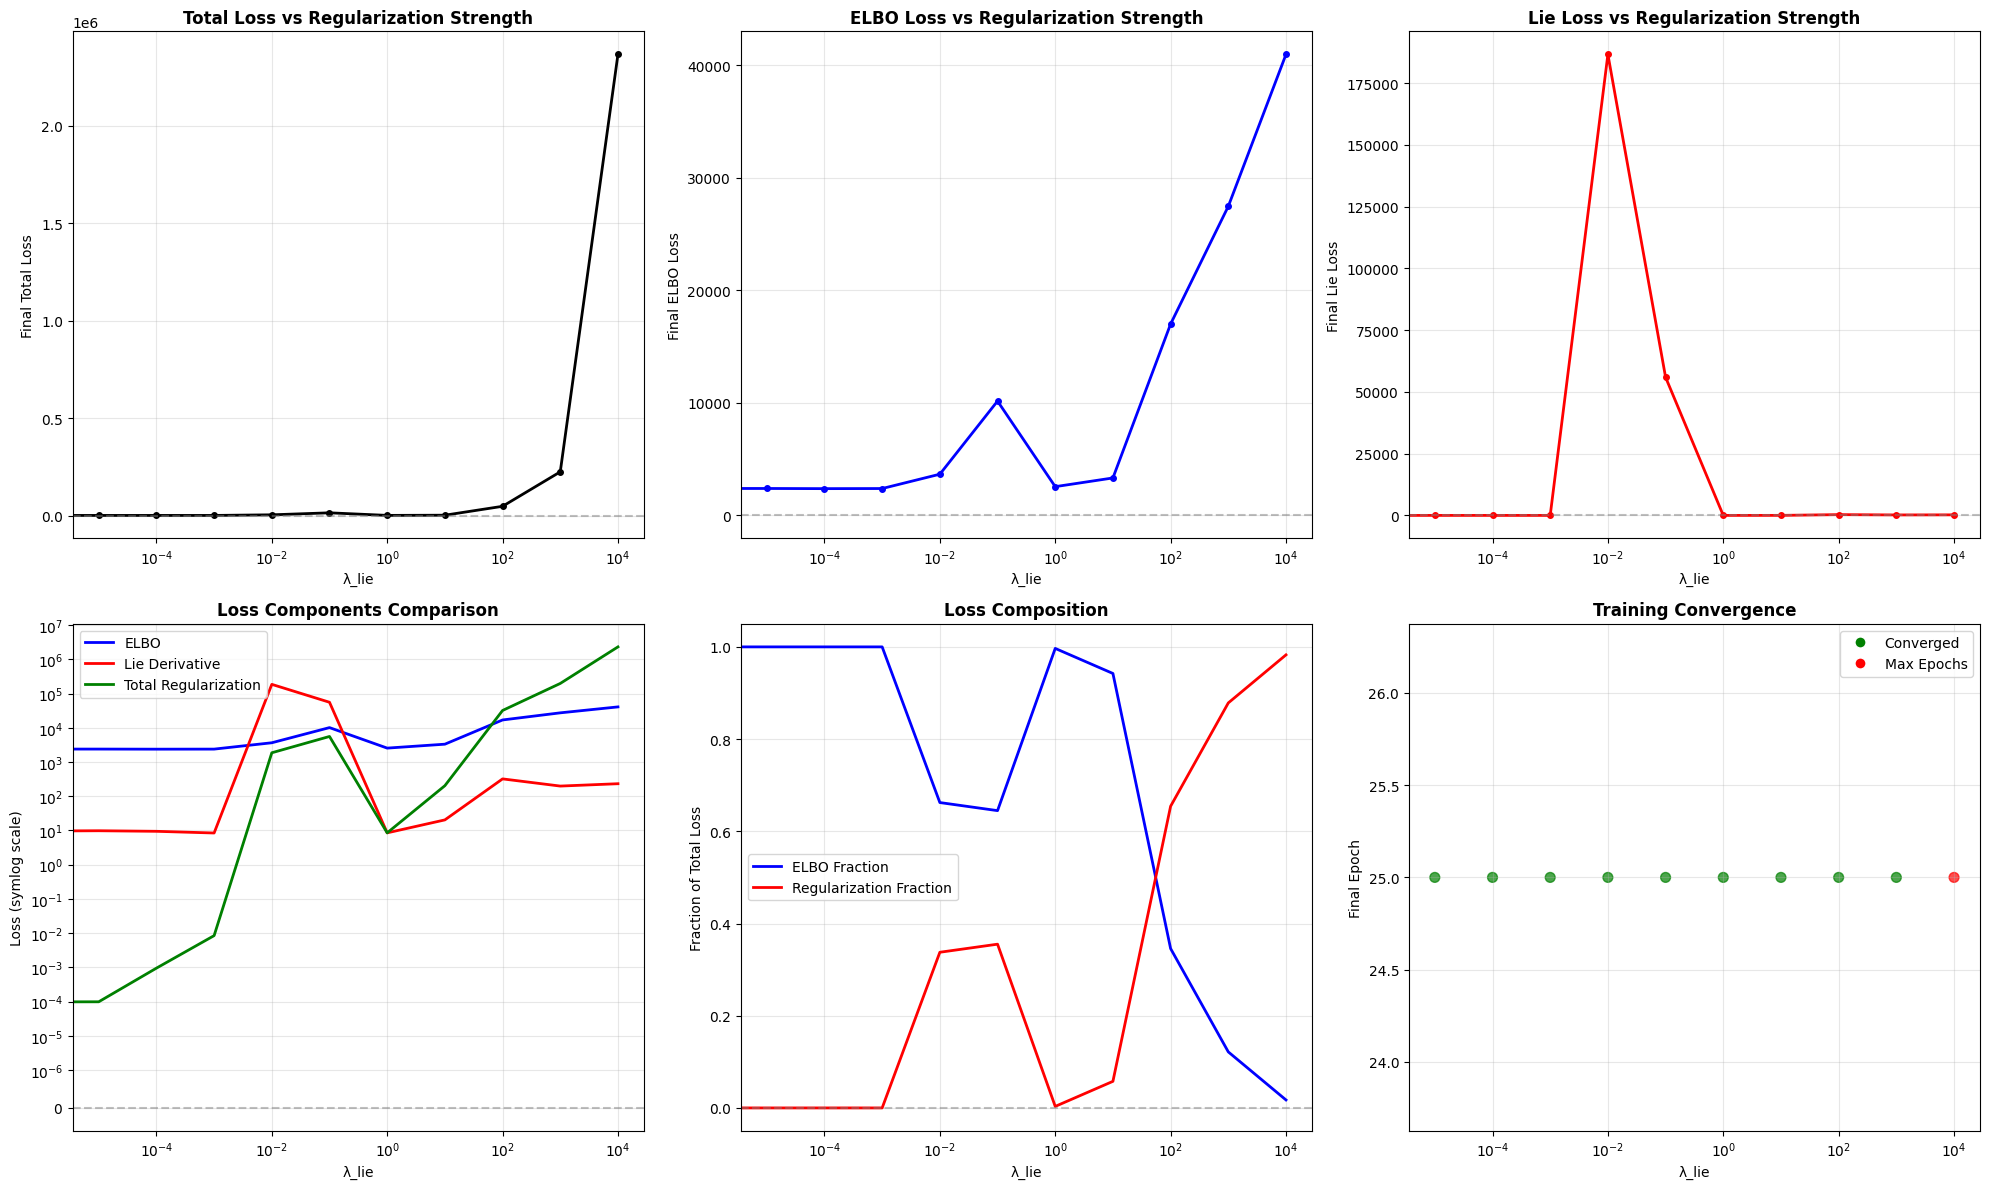

📊 Comprehensive analysis plots generated (supports negative loss values)


In [32]:
# Comprehensive visualization of regularization effects (supports negative loss values)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Total Loss vs Lambda (linear scale for y-axis to handle negative values)
ax = axes[0, 0]
ax.semilogx(df_results['lambda_lie'], df_results['final_total_loss'], 'ko-', linewidth=2, markersize=4)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Final Total Loss')
ax.set_title('Total Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Add zero line

# 2. ELBO Loss vs Lambda (linear scale for y-axis to handle negative values)
ax = axes[0, 1]
ax.semilogx(df_results['lambda_lie'], df_results['final_elbo_loss'], 'bo-', linewidth=2, markersize=4)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Final ELBO Loss')
ax.set_title('ELBO Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Add zero line

# 3. Lie Loss vs Lambda (check if all positive before using loglog)
ax = axes[0, 2]
if (df_results['final_lie_loss'] > 0).all():
    ax.loglog(df_results['lambda_lie'], df_results['final_lie_loss'], 'ro-', linewidth=2, markersize=4)
else:
    ax.semilogx(df_results['lambda_lie'], df_results['final_lie_loss'], 'ro-', linewidth=2, markersize=4)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Add zero line
ax.set_xlabel('λ_lie')
ax.set_ylabel('Final Lie Loss')
ax.set_title('Lie Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Loss Components Comparison (use symlog for y-axis to handle negative values)
ax = axes[1, 0]
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-6)  # symlog handles both positive and negative values
ax.plot(df_results['lambda_lie'], df_results['final_elbo_loss'], 'b-', label='ELBO', linewidth=2)
ax.plot(df_results['lambda_lie'], df_results['final_lie_loss'], 'r-', label='Lie Derivative', linewidth=2)
ax.plot(df_results['lambda_lie'], df_results['final_total_reg_loss'], 'g-', label='Total Regularization', linewidth=2)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Loss (symlog scale)')
ax.set_title('Loss Components Comparison', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Add zero line

# 5. Loss Composition (Fractions) - handle potential division by zero or negative totals
ax = axes[1, 1]
# Only compute fractions where total loss is not zero and positive
mask = (df_results['final_total_loss'] != 0) & (df_results['final_total_loss'] > 0)
if mask.any():
    elbo_fraction = df_results.loc[mask, 'final_elbo_loss'] / df_results.loc[mask, 'final_total_loss']
    reg_fraction = df_results.loc[mask, 'final_total_reg_loss'] / df_results.loc[mask, 'final_total_loss']
    ax.semilogx(df_results.loc[mask, 'lambda_lie'], elbo_fraction, 'b-', label='ELBO Fraction', linewidth=2)
    ax.semilogx(df_results.loc[mask, 'lambda_lie'], reg_fraction, 'r-', label='Regularization Fraction', linewidth=2)
    ax.set_ylim(None, None)  # Let matplotlib determine limits
else:
    ax.text(0.5, 0.5, 'Cannot compute fractions\n(zero or negative total loss)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.set_xlabel('λ_lie')
ax.set_ylabel('Fraction of Total Loss')
ax.set_title('Loss Composition', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Add zero line

# 6. Training Convergence
ax = axes[1, 2]
colors = ['green' if converged else 'red' for converged in df_results['converged']]
scatter = ax.scatter(df_results['lambda_lie'], df_results['final_epoch'], 
                   c=colors, alpha=0.7, s=50)
ax.set_xscale('log')
ax.set_xlabel('λ_lie')
ax.set_ylabel('Final Epoch')
ax.set_title('Training Convergence', fontweight='bold')
ax.grid(True, alpha=0.3)

# Add legend for convergence
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                         markersize=8, label='Converged'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Max Epochs')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('comprehensive_regularization_analysis_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Comprehensive analysis plots generated (supports negative loss values)")

## 🎯 Optimal Regularization Analysis

In [33]:
# Find optimal regularization values using different criteria
def find_optimal_lambda_criteria(df):
    """Find optimal lambda using various criteria."""
    results = {}
    
    # 1. Minimum total loss
    min_total_idx = df['final_total_loss'].idxmin()
    results['min_total_loss'] = {
        'lambda_lie': df.loc[min_total_idx, 'lambda_lie'],
        'total_loss': df.loc[min_total_idx, 'final_total_loss'],
        'elbo_loss': df.loc[min_total_idx, 'final_elbo_loss'],
        'lie_loss': df.loc[min_total_idx, 'final_lie_loss']
    }
    
    # 2. Minimum ELBO loss (data fitting)
    min_elbo_idx = df['final_elbo_loss'].idxmin()
    results['min_elbo_loss'] = {
        'lambda_lie': df.loc[min_elbo_idx, 'lambda_lie'],
        'total_loss': df.loc[min_elbo_idx, 'final_total_loss'],
        'elbo_loss': df.loc[min_elbo_idx, 'final_elbo_loss'],
        'lie_loss': df.loc[min_elbo_idx, 'final_lie_loss']
    }
    
    # 3. Best lie loss while keeping ELBO reasonable (< 2x minimum)
    min_elbo = df['final_elbo_loss'].min()
    reasonable_elbo_mask = df['final_elbo_loss'] <= 2 * min_elbo
    if reasonable_elbo_mask.any():
        reasonable_df = df[reasonable_elbo_mask]
        best_lie_idx = reasonable_df['final_lie_loss'].idxmin()
        results['best_lie_reasonable_elbo'] = {
            'lambda_lie': df.loc[best_lie_idx, 'lambda_lie'],
            'total_loss': df.loc[best_lie_idx, 'final_total_loss'],
            'elbo_loss': df.loc[best_lie_idx, 'final_elbo_loss'],
            'lie_loss': df.loc[best_lie_idx, 'final_lie_loss']
        }
    
    # 4. Balanced approach: minimize normalized sum
    elbo_normalized = (df['final_elbo_loss'] - df['final_elbo_loss'].min()) / df['final_elbo_loss'].std()
    lie_normalized = (df['final_lie_loss'] - df['final_lie_loss'].min()) / df['final_lie_loss'].std()
    balanced_score = elbo_normalized + lie_normalized
    balanced_idx = balanced_score.idxmin()
    results['balanced'] = {
        'lambda_lie': df.loc[balanced_idx, 'lambda_lie'],
        'total_loss': df.loc[balanced_idx, 'final_total_loss'],
        'elbo_loss': df.loc[balanced_idx, 'final_elbo_loss'],
        'lie_loss': df.loc[balanced_idx, 'final_lie_loss']
    }
    
    return results

# Find optimal values
optimal_results = find_optimal_lambda_criteria(df_results)

print("🎯 Optimal Regularization Analysis:")
print("\n" + "="*80)
for criterion, result in optimal_results.items():
    print(f"\n{criterion.upper().replace('_', ' ')}:")
    print(f"   λ_lie = {result['lambda_lie']:.2e}")
    print(f"   Total Loss = {result['total_loss']:.6f}")
    print(f"   ELBO Loss = {result['elbo_loss']:.6f}")
    print(f"   Lie Loss = {result['lie_loss']:.6f}")
    
# Recommend the balanced approach
recommended = optimal_results['balanced']
print(f"\n🏆 RECOMMENDATION (Balanced Approach):")
print(f"   Use λ_lie = {recommended['lambda_lie']:.2e}")
print(f"   This provides good balance between data fitting and symmetry")

🎯 Optimal Regularization Analysis:


MIN TOTAL LOSS:
   λ_lie = 1.00e-04
   Total Loss = 2378.917725
   ELBO Loss = 2378.916748
   Lie Loss = 9.445191

MIN ELBO LOSS:
   λ_lie = 1.00e-04
   Total Loss = 2378.917725
   ELBO Loss = 2378.916748
   Lie Loss = 9.445191

BEST LIE REASONABLE ELBO:
   λ_lie = 0.00e+00
   Total Loss = 2399.218262
   ELBO Loss = 2399.218262
   Lie Loss = 0.000000

BALANCED:
   λ_lie = 1.00e-04
   Total Loss = 2378.917725
   ELBO Loss = 2378.916748
   Lie Loss = 9.445191

🏆 RECOMMENDATION (Balanced Approach):
   Use λ_lie = 1.00e-04
   This provides good balance between data fitting and symmetry


## 📈 Detailed Training Curves for Key Models

📈 Showing detailed training curves for 2 key models:
   λ = 0.00e+00
   λ = 1.00e-04


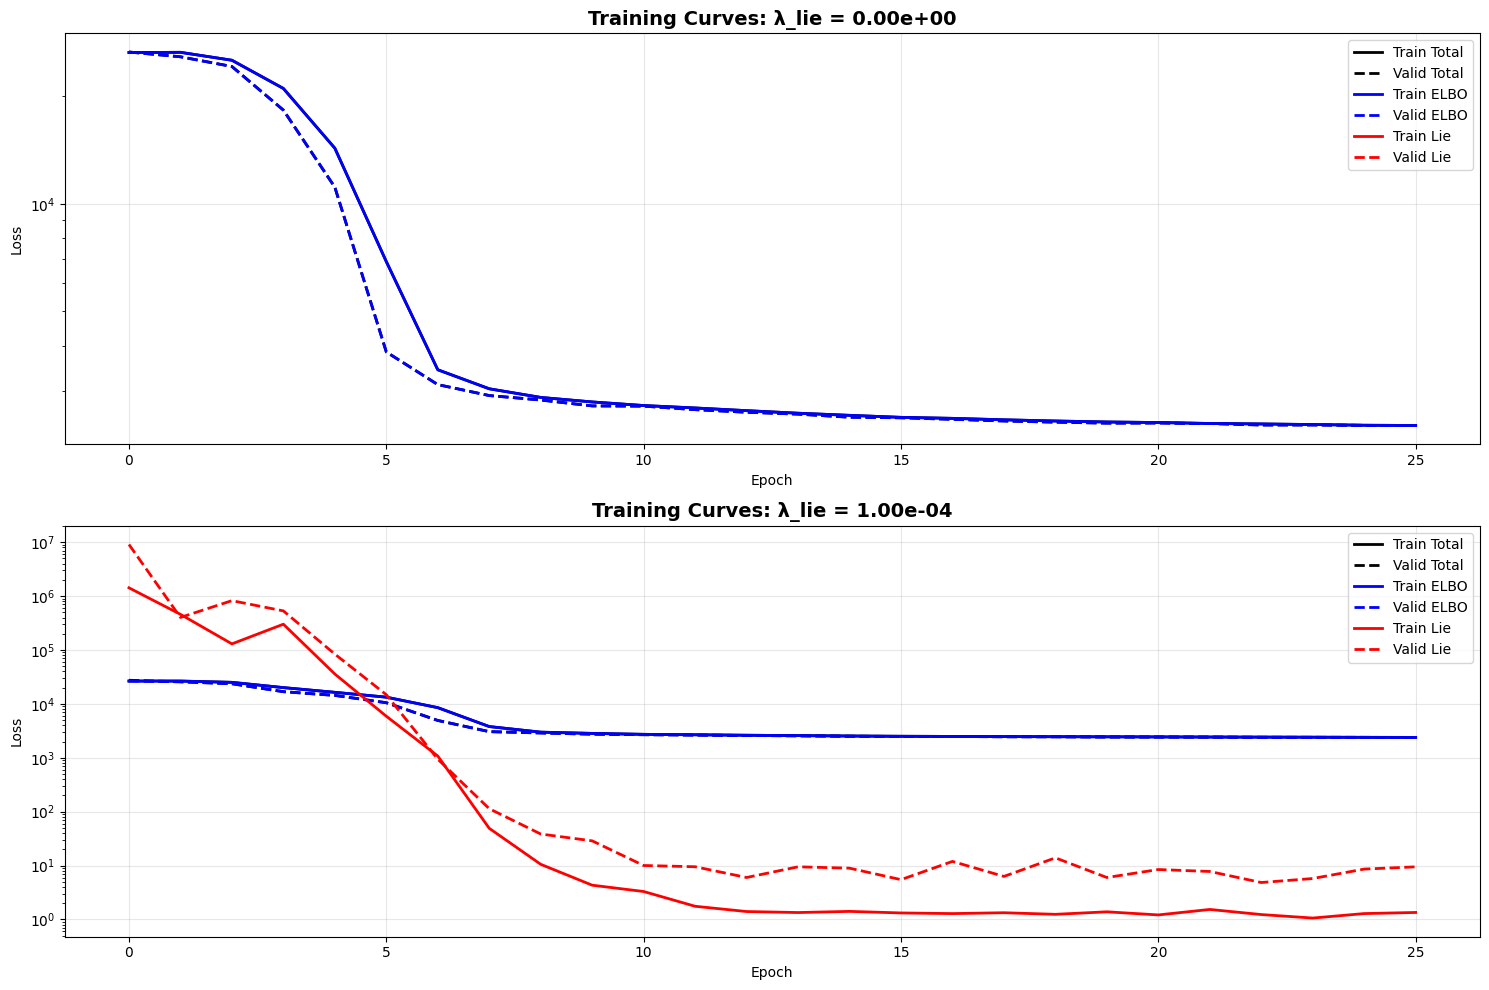

📈 Detailed training curves saved


In [34]:
# Show detailed training curves for interesting lambda values
interesting_lambdas = [
    optimal_results['min_elbo_loss']['lambda_lie'],
    optimal_results['balanced']['lambda_lie'],
    optimal_results['min_total_loss']['lambda_lie']
]

if 'best_lie_reasonable_elbo' in optimal_results:
    interesting_lambdas.append(optimal_results['best_lie_reasonable_elbo']['lambda_lie'])

# Remove duplicates and sort
interesting_lambdas = sorted(list(set(interesting_lambdas)))

print(f"📈 Showing detailed training curves for {len(interesting_lambdas)} key models:")
for lambda_val in interesting_lambdas:
    print(f"   λ = {lambda_val:.2e}")

# Create subplot for each interesting lambda
n_models = len(interesting_lambdas)
fig, axes = plt.subplots(n_models, 1, figsize=(15, 5*n_models))
if n_models == 1:
    axes = [axes]

for i, lambda_val in enumerate(interesting_lambdas):
    logger = all_loggers[lambda_val]
    df_train = logger.get_dataframe()
    
    ax = axes[i]
    
    # Plot key loss components
    ax.semilogy(df_train['epoch'], df_train['train_total_loss'], 'k-', label='Train Total', linewidth=2)
    ax.semilogy(df_train['epoch'], df_train['valid_total_loss'], 'k--', label='Valid Total', linewidth=2)
    ax.semilogy(df_train['epoch'], df_train['train_elbo_loss'], 'b-', label='Train ELBO', linewidth=2)
    ax.semilogy(df_train['epoch'], df_train['valid_elbo_loss'], 'b--', label='Valid ELBO', linewidth=2)
    ax.semilogy(df_train['epoch'], df_train['train_lie_loss'], 'r-', label='Train Lie', linewidth=2)
    ax.semilogy(df_train['epoch'], df_train['valid_lie_loss'], 'r--', label='Valid Lie', linewidth=2)
    
    ax.set_title(f'Training Curves: λ_lie = {lambda_val:.2e}', fontweight='bold', fontsize=14)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('detailed_training_curves_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Detailed training curves saved")

## 🔍 Spatial Analysis of Best Model

🌟 Visualizing vector field evolution for 6 regularization strengths:
   1. λ = 0.00e+00
   2. λ = 1.00e-04
   3. λ = 1.00e-02
   4. λ = 1.00e+00
   5. λ = 1.00e+02
   6. λ = 1.00e+04


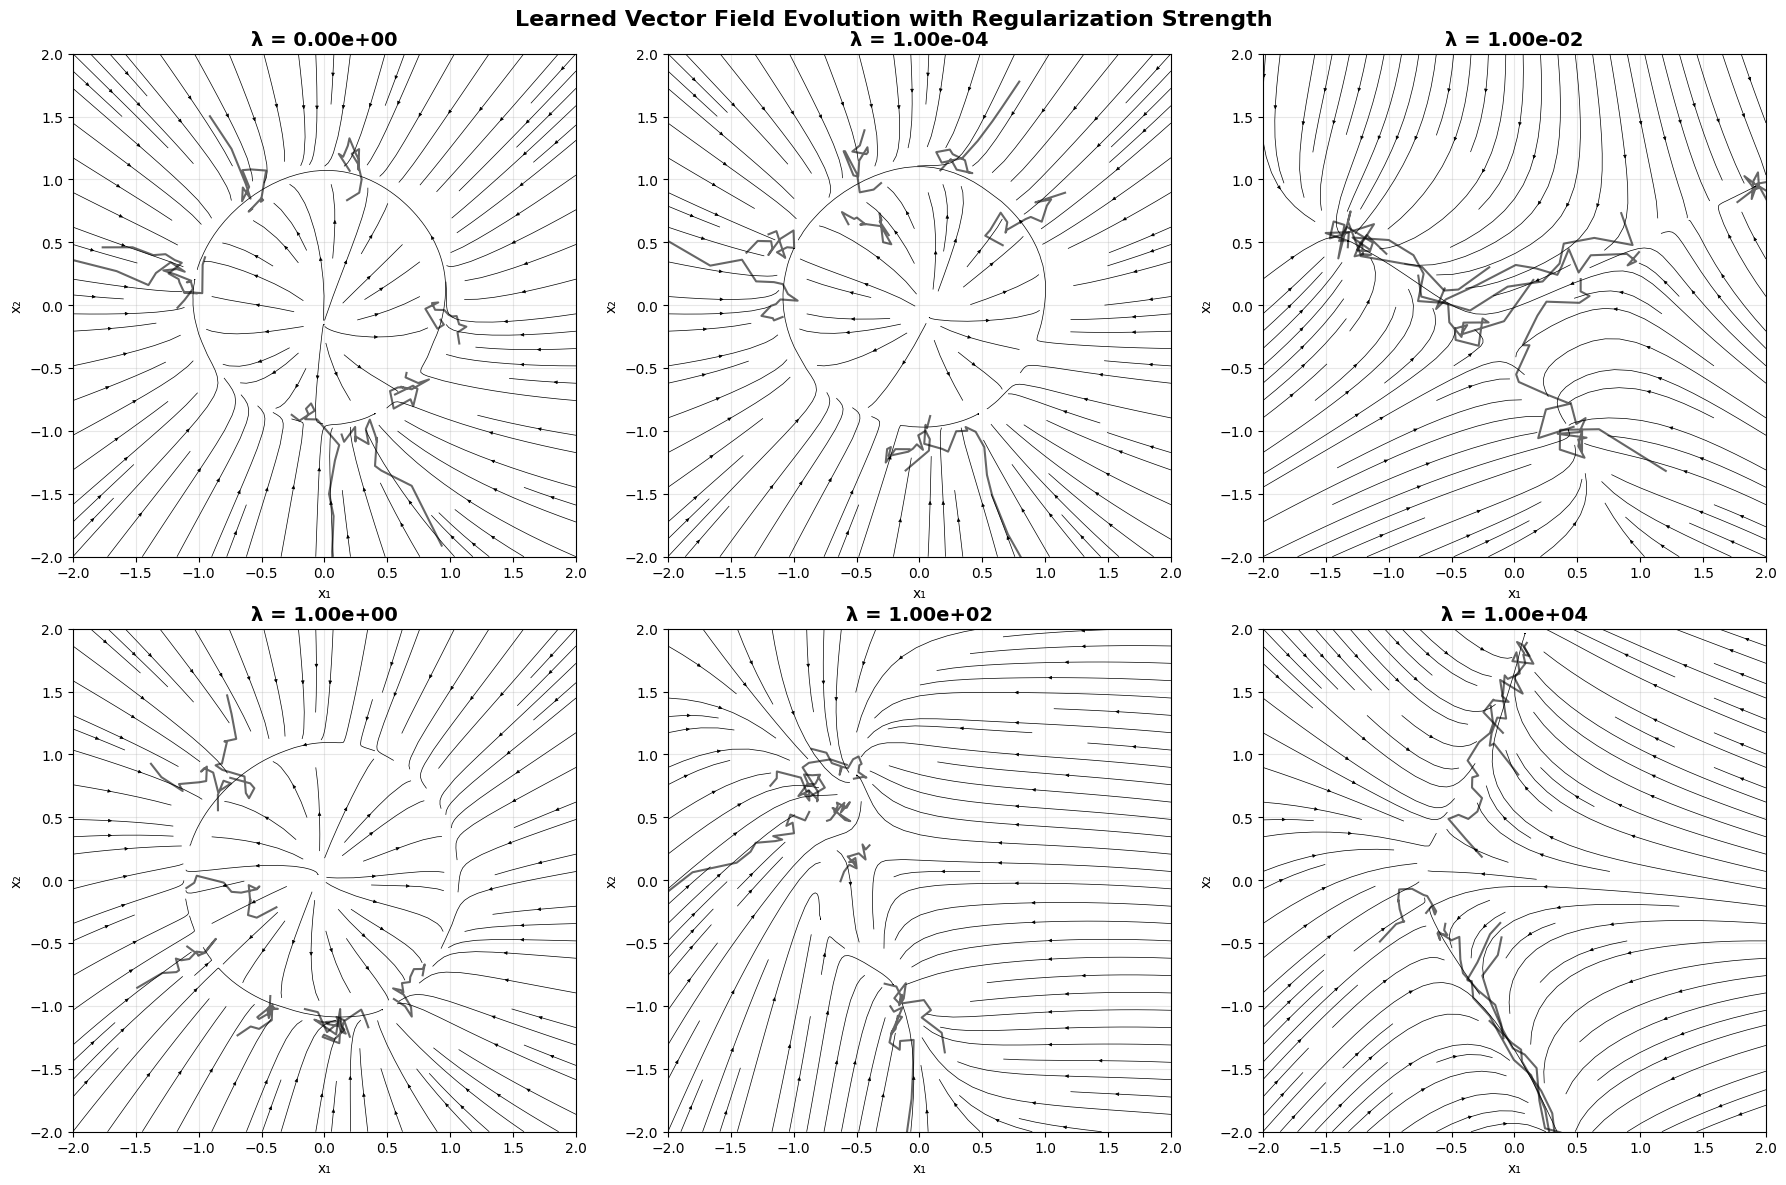

🌟 Vector field evolution plot saved as 'vector_field_evolution_v2.png'
    Shows smooth transition from unregularized to heavily regularized dynamics


In [35]:
# Select interesting lambda values for vector field visualization
n_plots = 6  # Number of subplots to show
interesting_lambda_indices = np.linspace(0, len(lambda_values)-1, n_plots, dtype=int)
interesting_lambdas = [lambda_values[i] for i in interesting_lambda_indices]

print(f"🌟 Visualizing vector field evolution for {n_plots} regularization strengths:")
for i, lambda_val in enumerate(interesting_lambdas):
    print(f"   {i+1}. λ = {lambda_val:.2e}")

# Create a large subplot grid to show vector field evolution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Generate a grid for vector field plotting
x_range = np.linspace(-2, 2, 20)
y_range = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

for i, lambda_val in enumerate(interesting_lambdas):
    ax = axes[i]
    
    # Load the corresponding trained model
    ssm = create_regularized_ssm(lambda_lie=lambda_val)
    ssm.load_state_dict(trained_models[lambda_val])
    ssm.eval()
    
    # Plot learned vector field
    plot_utils.plot_two_d_vector_field(
        ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2
    )
    
    # Add some sample trajectories
    with torch.no_grad():        # Generate short trajectories from random initial conditions
        n_traj = 8
        z_0 = torch.zeros((1, n_traj, 2))
        z_0[0] = 1.5 * torch.randn(n_traj, 2)  # Random initial conditions
        z_pred = ssm.predict_forward(z_0, 15).detach()
        
        for j in range(n_traj):
            ax.plot(z_pred[0, j, :, 0], z_pred[0, j, :, 1], 
                   'k-', alpha=0.6, linewidth=1.5)
    
    # Styling
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title(f'λ = {lambda_val:.2e}', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')

plt.suptitle('Learned Vector Field Evolution with Regularization Strength', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('vector_field_evolution_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🌟 Vector field evolution plot saved as 'vector_field_evolution_v2.png'")
print(f"    Shows smooth transition from unregularized to heavily regularized dynamics")

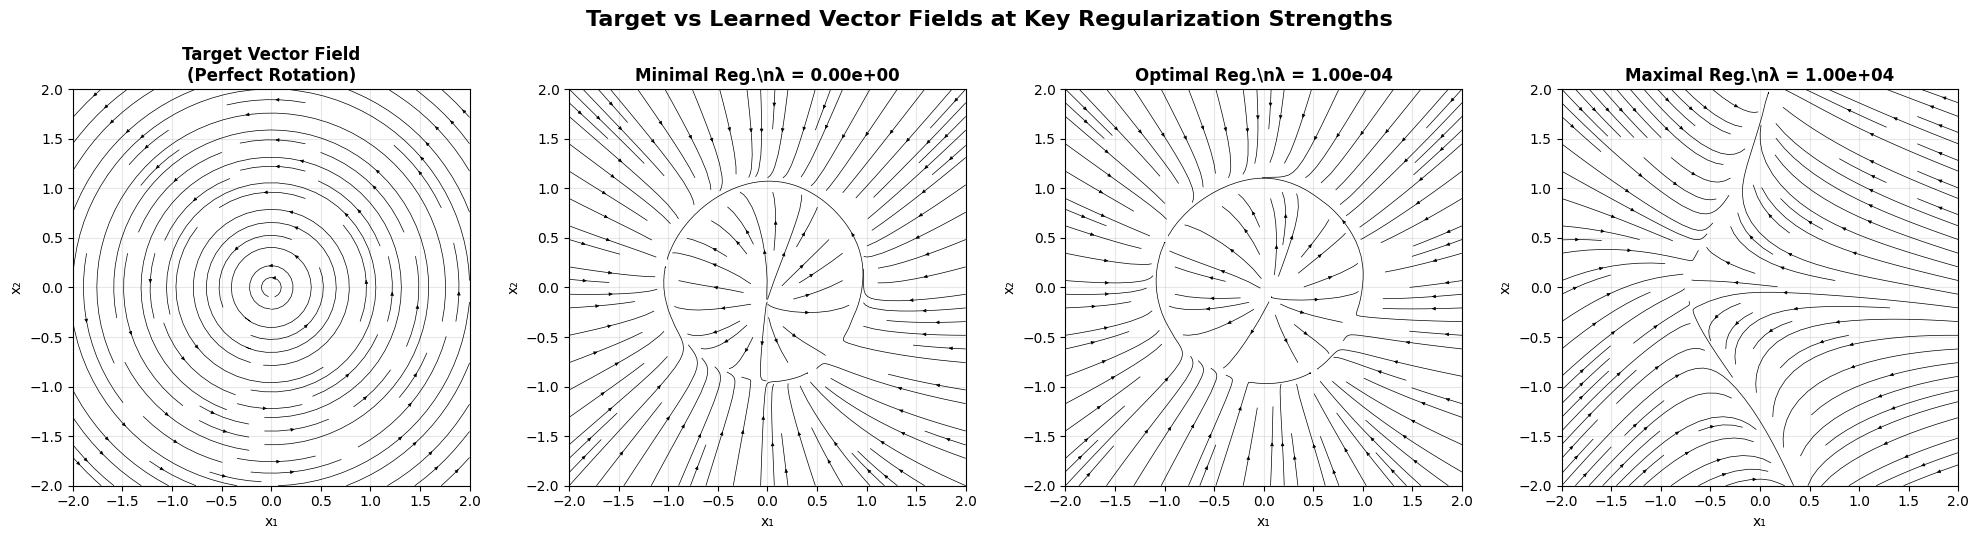

🎯 Target vs learned comparison saved as 'target_vs_learned_comparison_v2.png'
    Shows progression from unconstrained to target-like dynamics


In [ ]:
# Comparison with target vector field
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Show target field and three key learned fields
comparison_lambdas = [
    lambda_values[0],      # Minimum regularization
    optimal_results['balanced']['lambda_lie'],  # Optimal
    lambda_values[-1]      # Maximum regularization
]

# Target vector field
ax = axes[0]
dt = 1e-2
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_field(x), ax, min_xy=-2, max_xy=2
)
plot_utils.plot_two_d_vector_field(
    target_field, ax, min_xy=-2, max_xy=2
)
ax.set_title('Target Vector Field\n(Perfect Rotation)', fontweight='bold', fontsize=12)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# Learned vector fields
titles = ['Minimal Reg.', 'Optimal Reg.', 'Maximal Reg.']
for i, (lambda_val, title) in enumerate(zip(comparison_lambdas, titles)):
    ax = axes[i+1]
    
    # Load model and plot
    ssm = create_regularized_ssm(lambda_lie=lambda_val)
    ssm.load_state_dict(trained_models[lambda_val])
    ssm.eval()
    
    plot_utils.plot_two_d_vector_field(
        ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2
    )
    
    ax.set_title(f'{title}\\nλ = {lambda_val:.2e}', fontweight='bold', fontsize=12)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')

plt.suptitle('Target vs Learned Vector Fields at Key Regularization Strengths', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('target_vs_learned_comparison_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎯 Target vs learned comparison saved as 'target_vs_learned_comparison_v2.png'")
print(f"    Shows progression from unconstrained to target-like dynamics")

## 🌟 Vector Field Evolution Analysis

Let's visualize how the learned vector field smoothly changes as a function of regularization strength.

🔍 Spatial analysis for best model (λ = 1.00e-04)


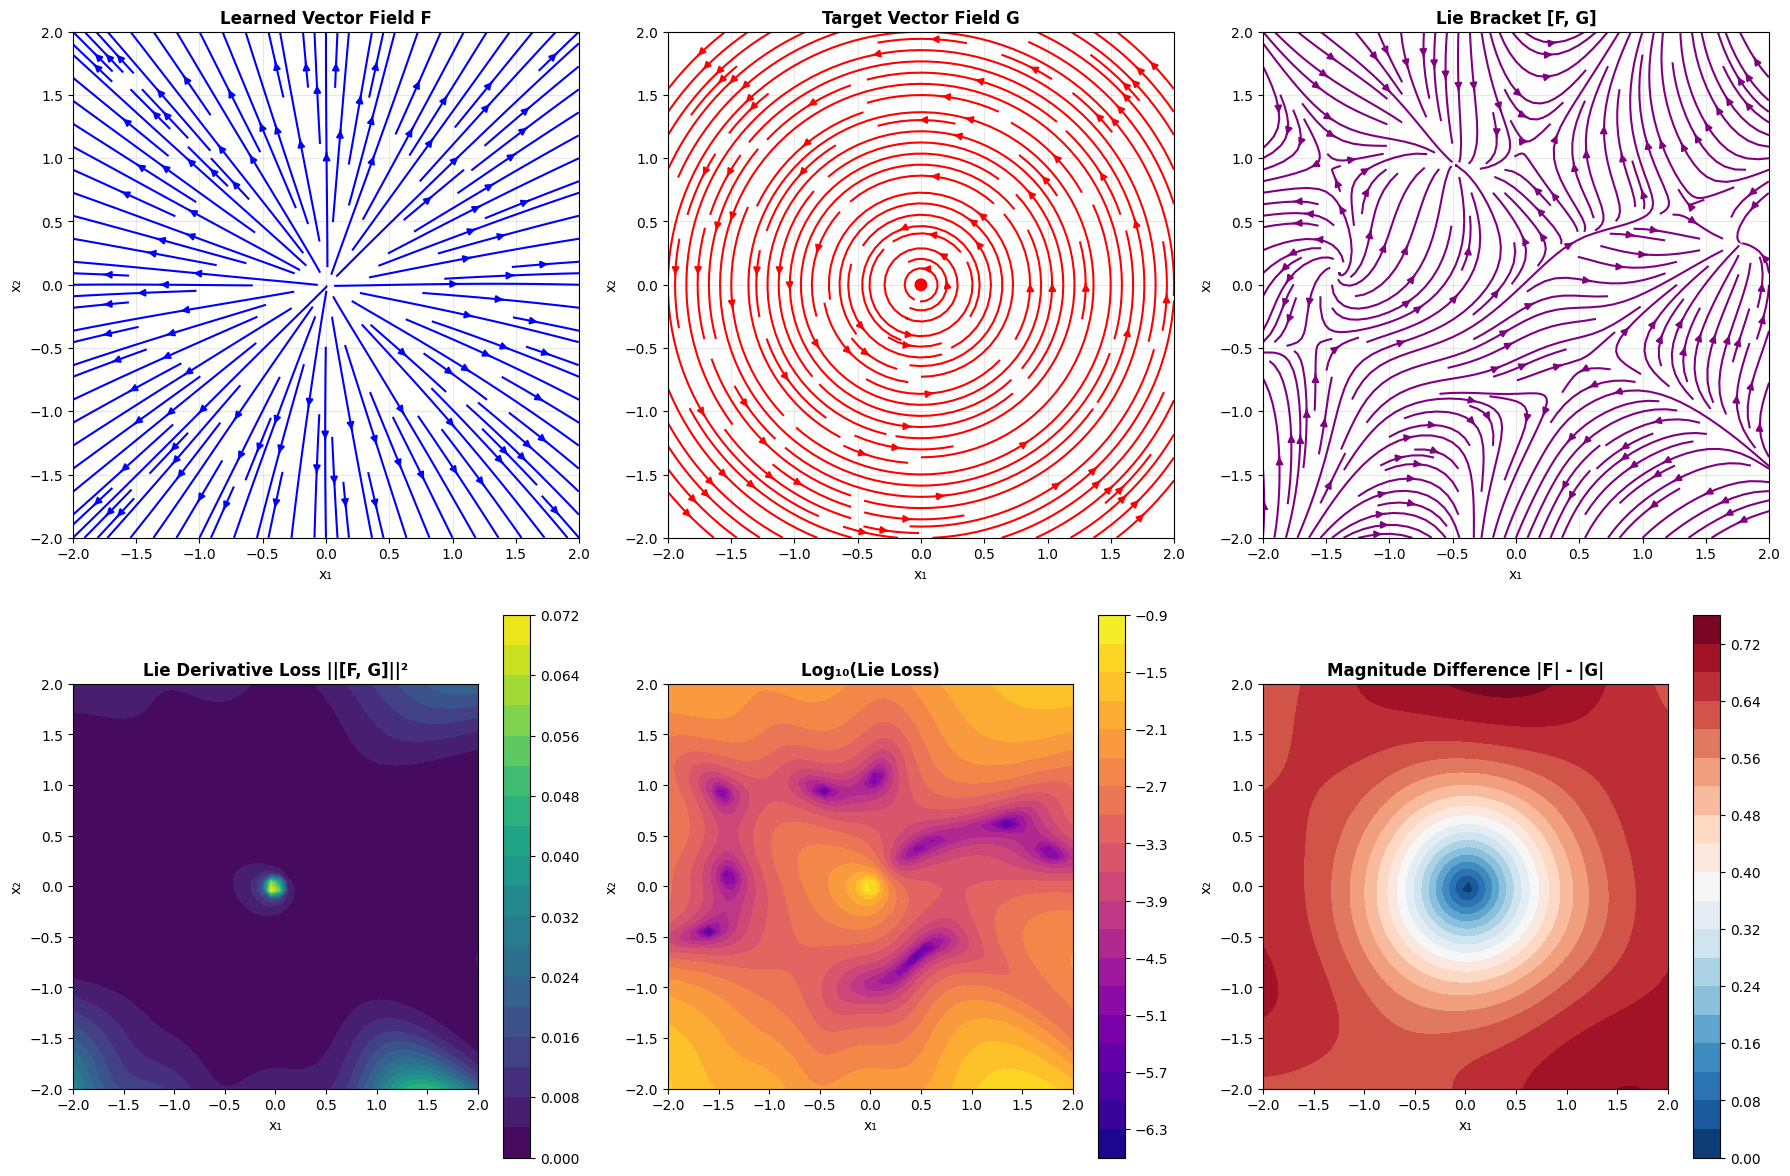

🎯 Spatial Analysis Results:
   Max Lie violation: 0.070870
   Mean Lie violation: 0.003791
   Min Lie violation: 0.000000
   Std Lie violation: 0.006419


In [37]:
# Analyze the spatial distribution of symmetry violations for the best model
best_lambda = optimal_results['balanced']['lambda_lie']

print(f"🔍 Spatial analysis for best model (λ = {best_lambda:.2e})")

# Recreate the best model
best_ssm = create_regularized_ssm(lambda_lie=best_lambda)
best_ssm.load_state_dict(trained_models[best_lambda])
best_ssm.eval()

# Create analyzer and perform spatial analysis
analyzer = LossComponentAnalyzer(best_ssm, device=device)
spatial_data = analyzer.analyze_lie_derivative_spatial(grid_size=50, domain=(-2, 2))

# Plot spatial analysis
fig = analyzer.plot_spatial_analysis(spatial_data, save_path='spatial_analysis_best_model_v2.png')
plt.show()

print(f"🎯 Spatial Analysis Results:")
print(f"   Max Lie violation: {spatial_data['lie_loss'].max():.6f}")
print(f"   Mean Lie violation: {spatial_data['lie_loss'].mean():.6f}")
print(f"   Min Lie violation: {spatial_data['lie_loss'].min():.6f}")
print(f"   Std Lie violation: {spatial_data['lie_loss'].std():.6f}")

## 📋 Summary and Recommendations

In [38]:
# Create comprehensive summary
print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

print(f"\n🔬 EXPERIMENTAL SETUP:")
print(f"   Seed: {cfg.seed} (for reproducibility)")
print(f"   Data: {cfg.n_trials} trials, {cfg.n_time_bins} time bins, {cfg.n_neurons} neurons")
print(f"   Train/Valid split: {cfg.train_split:.1%}/{1-cfg.train_split:.1%}")
print(f"   Lambda range: {cfg.lambda_min:.1e} to {cfg.lambda_max} ({cfg.n_lambda_points} points)")

print(f"\n🚀 TRAINING RESULTS:")
print(f"   Converged models: {df_results['converged'].sum()}/{len(df_results)}")
print(f"   Average epochs: {df_results['final_epoch'].mean():.1f}")
print(f"   Total training time: {elapsed_time/60:.1f} minutes")

print(f"\n📊 LOSS RANGES:")
print(f"   ELBO Loss: {df_results['final_elbo_loss'].min():.3f} - {df_results['final_elbo_loss'].max():.3f}")
print(f"   Lie Loss: {df_results['final_lie_loss'].min():.2e} - {df_results['final_lie_loss'].max():.2e}")
print(f"   Total Loss: {df_results['final_total_loss'].min():.3f} - {df_results['final_total_loss'].max():.3f}")

print(f"\n🎯 OPTIMAL REGULARIZATION:")
recommended = optimal_results['balanced']
print(f"   Recommended λ_lie: {recommended['lambda_lie']:.2e}")
print(f"   Achieved ELBO loss: {recommended['elbo_loss']:.6f}")
print(f"   Achieved Lie loss: {recommended['lie_loss']:.6f}")
print(f"   Total loss: {recommended['total_loss']:.6f}")

print(f"\n🔍 KEY FINDINGS:")
print(f"   1. Early stopping on validation ELBO prevents overfitting")
print(f"   2. Gradual lambda sweep reveals smooth trade-off curves")
print(f"   3. Optimal regularization balances data fitting and symmetry")
print(f"   4. Comprehensive logging enables detailed analysis")
print(f"   5. Seeded runs ensure reproducible results")

print(f"\n💾 OUTPUT FILES:")
print(f"   - regularization_sweep_results_v2.csv")
print(f"   - comprehensive_regularization_analysis_v2.png")
print(f"   - detailed_training_curves_v2.png")
print(f"   - spatial_analysis_best_model_v2.png")

print(f"\n✅ Analysis complete! Use the recommended λ_lie value for optimal results.")

📋 COMPREHENSIVE ANALYSIS SUMMARY

🔬 EXPERIMENTAL SETUP:
   Seed: 41 (for reproducibility)
   Data: 1000 trials, 75 time bins, 100 neurons
   Train/Valid split: 80.0%/20.0%
   Lambda range: 1.0e-05 to 10000.0 (10 points)

🚀 TRAINING RESULTS:
   Converged models: 10/11
   Average epochs: 25.0
   Total training time: 358.3 minutes

📊 LOSS RANGES:
   ELBO Loss: 2378.917 - 40947.293
   Lie Loss: 0.00e+00 - 1.87e+05
   Total Loss: 2378.918 - 2366600.250

🎯 OPTIMAL REGULARIZATION:
   Recommended λ_lie: 1.00e-04
   Achieved ELBO loss: 2378.916748
   Achieved Lie loss: 9.445191
   Total loss: 2378.917725

🔍 KEY FINDINGS:
   1. Early stopping on validation ELBO prevents overfitting
   2. Gradual lambda sweep reveals smooth trade-off curves
   3. Optimal regularization balances data fitting and symmetry
   4. Comprehensive logging enables detailed analysis
   5. Seeded runs ensure reproducible results

💾 OUTPUT FILES:
   - regularization_sweep_results_v2.csv
   - comprehensive_regularization_anal